In [2]:
import sys
import math
import pickle
# import random
import numpy as np
import copy
from collections import Counter
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
sys.path.append('C:\Python36\Lib\site-packages')
import warnings
warnings.filterwarnings("ignore")

In [3]:
f2_tf_idf_vecs = pickle.load(open('./f2_tf_idf_vecs', 'rb'))
mapping = pickle.load(open('./mapping', 'rb'))
train_dict, test_dict = pickle.load(open('./train_and_test_dict', 'rb'))

<h3> Similarity matrix generating function</h3>

In [4]:
def get_sim_matr(tf_idf_vecs):
    sim_matr = cosine_similarity(tf_idf_vecs, tf_idf_vecs)
    min_val = np.min(sim_matr)
    if min_val < 0:
        max_val = np.max(sim_matr)
        sim_matr = (sim_matr - min_val)/(max_val - min_val)
    smoothing_val  = np.unique(sim_matr)[1]
    sim_matr += smoothing_val
    sim_matr = sim_matr / np.max(sim_matr, axis=1)
    return sim_matr

<h3> For F1 feature combination: countries (After PCA preserving eigen-energy: %)</h3>

In [6]:
f1_tf_idf_vecs = pickle.load(open('Vec_space_after_pca\\f1_phase2_comb_14', 'rb'))

In [7]:
f1_sim_mat = get_sim_matr(f1_tf_idf_vecs)

In [8]:
f1_dim = f1_tf_idf_vecs.shape[1]

In [9]:
np.min(f1_sim_mat)

0.0113083292045136

<h3> Train and Test functions </h3>

In [10]:
def user_pred_errors(user_ratings, ratio, sim_matr_1, sim_matr_2, mapping):
    movie_ids = list(user_ratings.keys())
    np.random.shuffle(movie_ids)
    train_pts = len(movie_ids) - int(0.2 * len(movie_ids))
    
    train_ratings = np.array([user_ratings[mid] for mid in movie_ids[:train_pts]])
    train_ind = [mapping.index(mid) for mid in movie_ids[:train_pts]]
    
    test_ratings = np.array([user_ratings[mid] for mid in movie_ids[train_pts:]])
    test_ind = [mapping.index(mid) for mid in movie_ids[train_pts:]]
    
    user_mean = np.mean(train_ratings)
    errors = []
    for i in range(len(test_ratings)):
        pred = 0
        sim_sum = 0
        for j in range(len(train_ratings)):
            sim_val = ((sim_matr_1[test_ind[i]][train_ind[j]] * ratio) + (sim_matr_2[test_ind[i]][train_ind[j]] * (1-ratio)))
            pred += sim_val * (train_ratings[j] - user_mean)
            sim_sum += sim_val
        pred = pred / sim_sum
        pred = pred + user_mean
        error = (pred - test_ratings[i])**2
        errors.append(error)
    return errors

In [11]:
def training(train_user_dict, sim_matr_1, sim_matr_2, mapping, start, incr): 
    a = []
    rmse = []
    print("Tested for alpha: ", end='')
    for alpha in np.arange(start, 1.01, incr):
        alpha = round(alpha,2)
        error = []
        for j in train_user_dict.keys():
            error += user_pred_errors(train_user_dict[j], alpha, sim_matr_1, sim_matr_2, mapping)
        error = np.array(error)
        mean_all = np.mean(error)
        sv = mean_all ** 0.5
        rmse.append(sv)
        a.append(alpha)
        print(alpha, end=' ')
    print()
    return a, rmse

In [12]:
def testing(test_user_dict, sim_matr_1, sim_matr_2, mapping, alpha): 
    error = []
    for j in test_user_dict.keys():
        error += user_pred_errors(test_user_dict[j], alpha, sim_matr_1, sim_matr_2, mapping)
    error = np.array(error)
    mean_all = np.mean(error)
    rmse = mean_all ** 0.5
    return rmse

In [13]:
def f1_train_test(f1_sim_matr, f2_sim_matr, mapping, train_dict, test_dict):
    alphas, rmse_list = training(train_dict, f1_sim_matr, f2_sim_matr, mapping, 0, 0.05)
    
    get_plot(alphas, rmse_list, axis_names=['Alpha (ratio)','RMSE'], title = 'RMSE plot for different parameter(alpha) values')
    min_ind = rmse_list.index(min(rmse_list[1:]))
    best_alpha = alphas[min_ind]
    train_rmse = round(rmse_list[min_ind], 4)
    
    test_rmse = round(testing(test_dict, f1_sim_matr, f2_sim_matr, mapping, best_alpha), 4)    
    print("Results:-  Alpha: ", best_alpha,"   Train RMSE: ", train_rmse, "   Test RMSE: ", test_rmse)
    return test_rmse, train_rmse, best_alpha

#### PCA functions, table and plot functions

In [14]:
def get_pca(tf_idf_vecs):
    pca_var = PCA(n_components=0.99).fit(tf_idf_vecs)
    evecs_all = pca_var.components_
    variance_ratios = pca_var.explained_variance_ratio_
    return evecs_all, variance_ratios

In [15]:
def get_test_data_pca(eig_energy_all, evecs_all, f1_sim_mat, f2_tf_idf_vecs, mapping, train_dict, test_dict):
    eig_energy = np.arange(0.50, 1.0, 0.05)
    eig_energy = np.append(eig_energy, [0.99])
    best_test_rmse = math.inf
    train_rmse_list, test_rmse_list, alpha_list, dim_list = [], [], [], []
    
    for lambda_val in eig_energy:
        count = 0
        lambda_val_first = eig_energy_all[0]
        while lambda_val_first < lambda_val:
            count += 1
            lambda_val_first += eig_energy_all[count]
        lambda_val_first -= eig_energy_all[count]
        eig_vecs = evecs_all[:count]
        pca_transformed = np.matmul(f2_tf_idf_vecs, eig_vecs.T)
        pca_trans_sim_mat = get_sim_matr(pca_transformed)
        print("Eigen energy: %8.5f" %(lambda_val_first))
        test_rmse, train_rmse, alpha = f1_train_test(f1_sim_mat, pca_trans_sim_mat, mapping, train_dict, test_dict)
        
        if test_rmse < best_test_rmse:
            best_test_rmse = test_rmse
            best_pca_transformed = copy.deepcopy(pca_transformed)
        
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        alpha_list.append(alpha)
        dim_list.append(pca_transformed.shape[1])
        
        print("---------------------------------------------------------------------")
    
    with open("Vec_space_after_pca\\f2_phase2", 'wb') as bpt:
        pickle.dump(best_pca_transformed, bpt)
    
    return train_rmse_list, test_rmse_list, alpha_list, dim_list, eig_energy

In [16]:
def get_plot(x, y, axis_names=['x-axis','y-axis'], title = '', dim_list = []):
    plt.figure(figsize=(12,5))
    plt.plot(x, y) 
    plt.xlabel(axis_names[0])
    plt.ylabel(axis_names[1])
    plt.xticks(x)
    plt.title(title,fontweight='bold')
    if dim_list:
        for i, txt in enumerate(dim_list):
            plt.annotate(txt, (x[i], y[i]))
    plt.grid()
    plt.show()

In [17]:
def get_table_per_feature_comb(var_ratio_list, f1_dim, f2_dim_list, alpha_list, train_rmse_list, test_rmse_list):
    x = PrettyTable()
    x.field_names = ["Index", "Variance ratio", "F1 dim", "F2 dim", "alpha", "Train RMSE", "Test RMSE"]
    for i in range(len(var_ratio_list)):
        x.add_row([str(i+1), round(var_ratio_list[i], 2), f1_dim, f2_dim_list[i], alpha_list[i], train_rmse_list[i], test_rmse_list[i]])
    print(x)

<h3> For F2 feature combination: overview</h3>

In [18]:
evecs_all, variance_ratios = get_pca(f2_tf_idf_vecs) 

Eigen energy:  0.49977
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


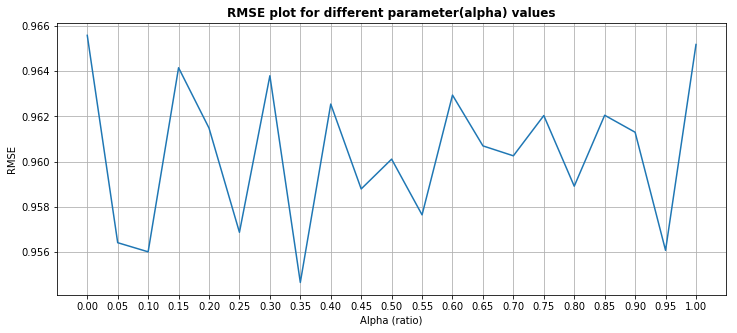

Results:-  Alpha:  0.35    Train RMSE:  0.9547    Test RMSE:  0.9356
---------------------------------------------------------------------
Eigen energy:  0.54986
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


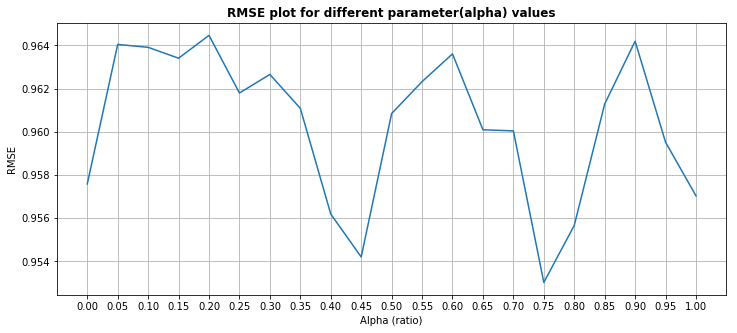

Results:-  Alpha:  0.75    Train RMSE:  0.953    Test RMSE:  0.9372
---------------------------------------------------------------------
Eigen energy:  0.59990
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


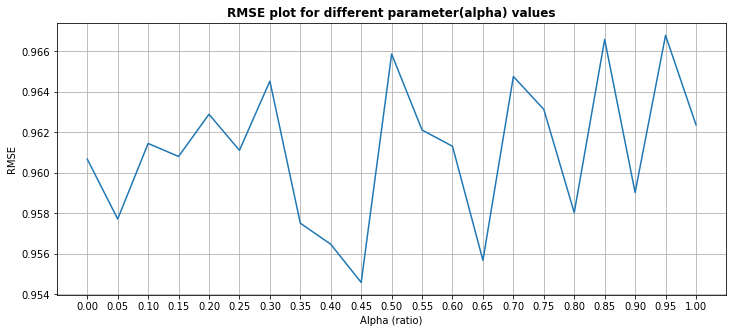

Results:-  Alpha:  0.45    Train RMSE:  0.9546    Test RMSE:  0.9365
---------------------------------------------------------------------
Eigen energy:  0.64981
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


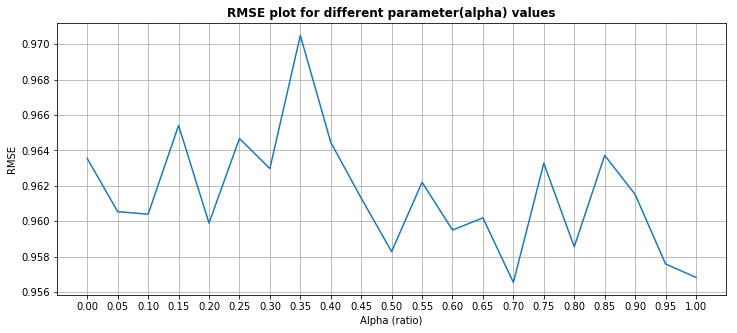

Results:-  Alpha:  0.7    Train RMSE:  0.9565    Test RMSE:  0.9323
---------------------------------------------------------------------
Eigen energy:  0.69982
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


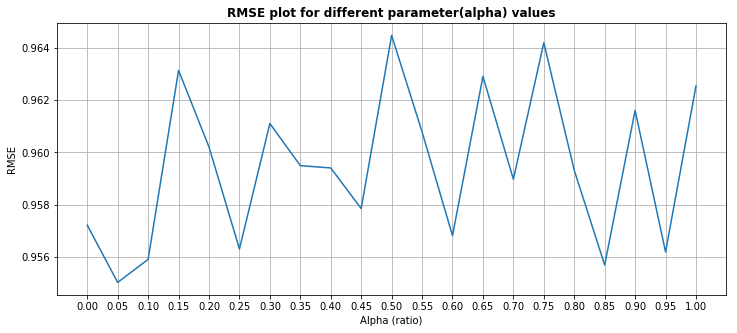

Results:-  Alpha:  0.05    Train RMSE:  0.955    Test RMSE:  0.9355
---------------------------------------------------------------------
Eigen energy:  0.74985
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


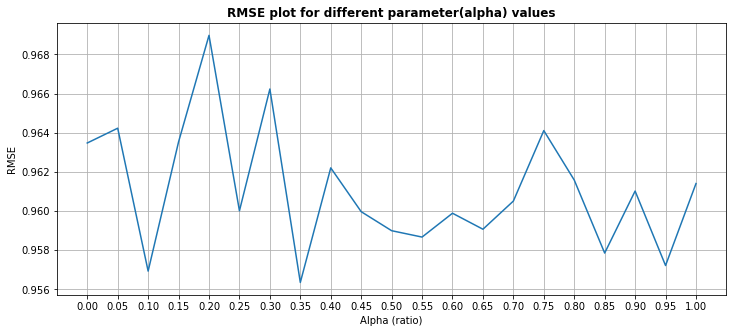

Results:-  Alpha:  0.35    Train RMSE:  0.9564    Test RMSE:  0.9284
---------------------------------------------------------------------
Eigen energy:  0.79987
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


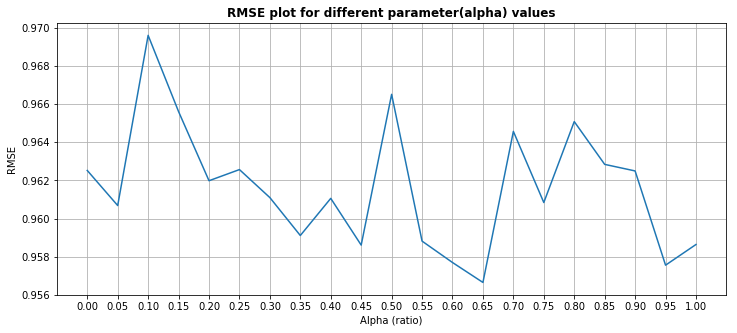

Results:-  Alpha:  0.65    Train RMSE:  0.9567    Test RMSE:  0.936
---------------------------------------------------------------------
Eigen energy:  0.84998
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


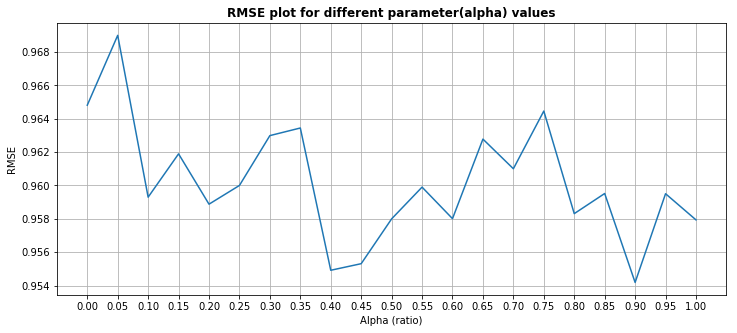

Results:-  Alpha:  0.9    Train RMSE:  0.9542    Test RMSE:  0.9438
---------------------------------------------------------------------
Eigen energy:  0.89991
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


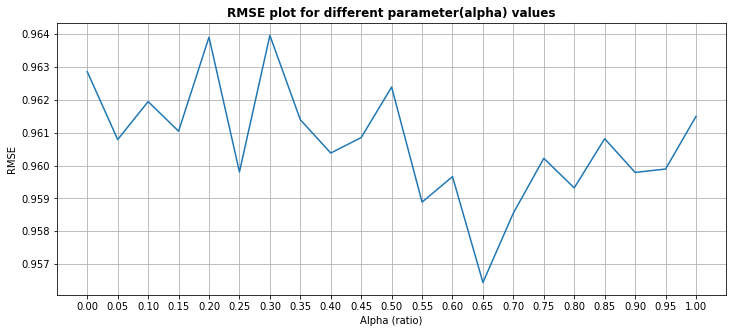

Results:-  Alpha:  0.65    Train RMSE:  0.9564    Test RMSE:  0.9435
---------------------------------------------------------------------
Eigen energy:  0.94994
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


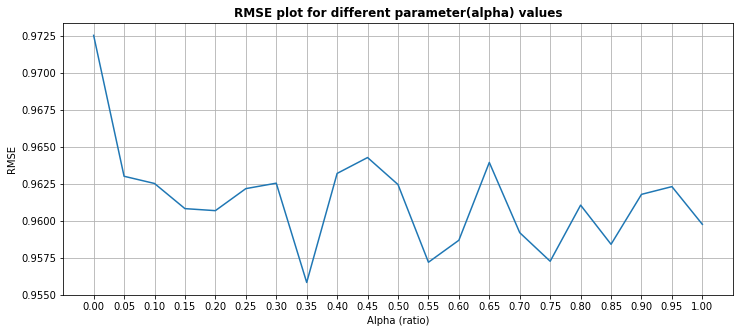

Results:-  Alpha:  0.35    Train RMSE:  0.9559    Test RMSE:  0.9359
---------------------------------------------------------------------
Eigen energy:  0.98996
Tested for alpha: 0.0 0.05 0.1 0.15 0.2 0.25 0.3 0.35 0.4 0.45 0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0 


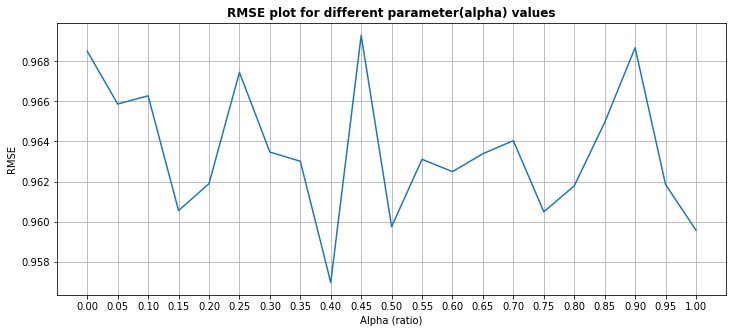

Results:-  Alpha:  0.4    Train RMSE:  0.957    Test RMSE:  0.9321
---------------------------------------------------------------------


In [19]:
train_rmse_list, test_rmse_list, alpha_list, f2_dim_list, threshold_var_list = get_test_data_pca(variance_ratios, \
                                                                                           evecs_all, \
                                                                                           f1_sim_mat, \
                                                                                           f2_tf_idf_vecs, \
                                                                                           mapping, \
                                                                                           train_dict, \
                                                                                           test_dict)

In [20]:
get_table_per_feature_comb(threshold_var_list, f1_dim, f2_dim_list, alpha_list, train_rmse_list, test_rmse_list)

+-------+----------------+--------+--------+-------+------------+-----------+
| Index | Variance ratio | F1 dim | F2 dim | alpha | Train RMSE | Test RMSE |
+-------+----------------+--------+--------+-------+------------+-----------+
|   1   |      0.5       |  1623  |  858   |  0.35 |   0.9547   |   0.9356  |
|   2   |      0.55      |  1623  |  1025  |  0.75 |   0.953    |   0.9372  |
|   3   |      0.6       |  1623  |  1211  |  0.45 |   0.9546   |   0.9365  |
|   4   |      0.65      |  1623  |  1418  |  0.7  |   0.9565   |   0.9323  |
|   5   |      0.7       |  1623  |  1650  |  0.05 |   0.955    |   0.9355  |
|   6   |      0.75      |  1623  |  1911  |  0.35 |   0.9564   |   0.9284  |
|   7   |      0.8       |  1623  |  2207  |  0.65 |   0.9567   |   0.936   |
|   8   |      0.85      |  1623  |  2549  |  0.9  |   0.9542   |   0.9438  |
|   9   |      0.9       |  1623  |  2953  |  0.65 |   0.9564   |   0.9435  |
|   10  |      0.95      |  1623  |  3460  |  0.35 |   0.9559   

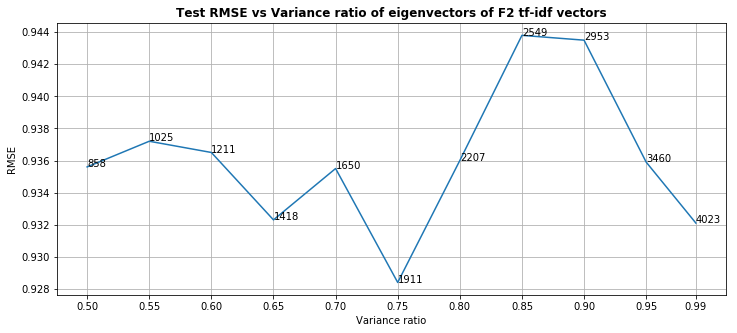

In [21]:
get_plot(threshold_var_list, test_rmse_list, axis_names=['Variance ratio','RMSE'], title = 'Test RMSE vs Variance ratio of eigenvectors of F2 tf-idf vectors', dim_list = f2_dim_list)